<a href="https://colab.research.google.com/github/jyotiraj-code/dissertation/blob/main/Expectation_Value_Calculation_and_Rehearsing_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [40]:
#Imports and Installations

!pip install -U git+https://github.com/jcmgray/quimb.git --quiet

%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from math import pi

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Number of Qubits

In [59]:
import random

def generate_qubits_number():
    return random.choice([i for i in range(1,10) if i % 2 == 0])

num_qubits = generate_qubits_number()
print(f"The generated even number is: {num_qubits}")


The generated even number is: 8


Generate a random quantum state

In [60]:
def generate_random_binary(length):
    return ''.join(random.choice(['0', '1']) for _ in range(length))

state_length = num_qubits
random_state = generate_random_binary(state_length)
print(f"The generated random state is: {random_state}")
print()


The generated random state is: 11101010



Encode the random quantum state:

[0, 1, 2, 3, 4, 5, 6, 7]


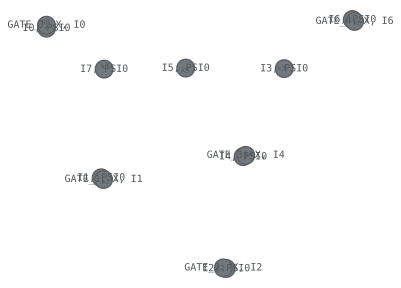

In [61]:
#First let us create the circuit so that we can store the states in their particular order
qc = qtn.Circuit(num_qubits)
#Getting the registers
regs = list(range(num_qubits))
#Encoding the values
for i, number in enumerate(random_state):
  if number =='1':
    qc.apply_gate('X', regs[i])
print(regs)

qc.psi.draw()
# Drawing the circuit
# qc.psi.to_dense()

Getting the QFT :

0
1
2
3


  0%|          | 0/2 [04:52<?, ?it/s]


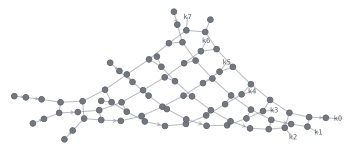

In [62]:
import numpy as np
import quimb.tensor as qtn

# Function to apply QFT rotations
def qft_rotations(circuit, qubits):
    for i in range(len(qubits)):
        circuit.apply_gate('H', qubits[i])
        for j in range(i+1, len(qubits)):
            lamda = np.pi / 2**(j - i)
            circuit.apply_gate('CPHASE', lamda, qubits[i], qubits[j])

# Function to apply the QFT to the circuit
def qft(circuit, qubits):
    qft_rotations(circuit, qubits)
    for i in range(len(qubits)//2):
        circuit.apply_gate('SWAP', qubits[i], qubits[len(qubits)-i-1])
        print(i)


# Apply the QFT to the entire circuit
qft(qc, range(num_qubits))

#Drawing the circuit again
qc.psi.draw()

Getting the QFT inverse too (Just for checking)

In [ ]:
def reverse_qft_rotations(circuit, qubits):
    for i in reversed(range(len(qubits))):
        for j in range(i+1, len(qubits)):
            lamda = np.pi / 2**(j - i)
            circuit.apply_gate('CPHASE', lamda, qubits[i], qubits[j])
        circuit.apply_gate('H', qubits[i])

# Function to apply the reverse QFT to the circuit
def reverse_qft(circuit, qubits):
    for i in range(len(qubits)//2):
        circuit.apply_gate('SWAP', qubits[i], qubits[len(qubits)-i-1])
    reverse_qft_rotations(circuit, qubits)
    return circuit

# Apply the reverse QFT to the entire circuit
reverse_qft(qc, range(num_qubits))

# Drawing the circuit again
# qc.psi.draw(), reverse_qft(qft(qc, range(num_qubits)), range(num_qubits)).psi.draw()

<Circuit(n=6, num_gates=52, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

Generating a graph for the edges: (Without the random process)

EdgeView([(1, 5), (2, 6), (5, 6), (6, 7)])

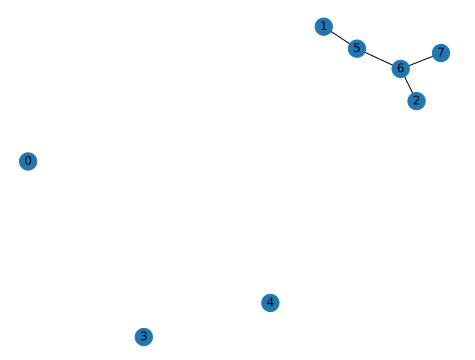

In [63]:
import networkx as nx
import random

# Define the number of nodes
num_nodes = num_qubits

# Calculate the number of edges based on the 2:1 node-to-edge ratio
num_edges = num_nodes // 2

# Create an empty graph
G = nx.Graph(seed = '666')
nx.draw(G)

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Randomly add edges until the desired number of edges is reached
while G.number_of_edges() < num_edges:
    # Pick two random nodes to connect with an edge
    u, v = random.sample(range(num_nodes), 2)
    # Add the edge if it doesn't already exist
    if not G.has_edge(u, v):
        G.add_edge(u, v)

# Draw the graph
nx.draw(G, with_labels=True)
display(nx.edges(G))

Defining the Optimizer:

In [64]:
import cotengra as ctg
import tqdm
# circ_qc=qft(qc, range(num_qubits))

opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={},
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)

Generating a graph for edges (without random process)

[(1, 2), (1, 5), (1, 3), (2, 0), (2, 5), (0, 4), (0, 3), (4, 3), (4, 5)]


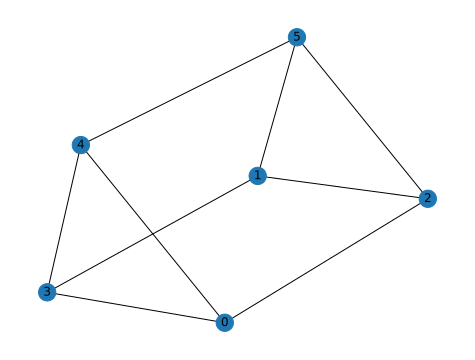

In [ ]:
import networkx as nx

reg = 3
n = num_qubits
seed = 666
F = nx.random_regular_graph(reg, n, seed=seed)

terms = {(i, j): 1 for i, j in F.edges}
nx.draw(F, with_labels = True)
print(F.edges())

Calculating the expectation value

In [65]:
!pip install tqdm --quiet
terms = {(i, j): 1 for i, j in G.edges}

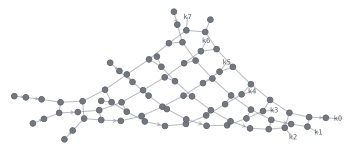

In [68]:
qc.psi.draw()

In [75]:
import tqdm
# edge=(0,2)
ZZ = qu.pauli('Z') & qu.pauli('Z')

local_exp_rehs = [
    qc.local_expectation_rehearse(weight * ZZ, edge, optimize=opt)
    for edge, weight in tqdm.tqdm(list(terms.items()))
]
print(local_exp_rehs)

# local_exp = [
#     qc.local_expectation(weight * ZZ, edge, optimize=opt)
#     for edge, weight in tqdm.tqdm(list(terms.items()))
# ]
# print(local_exp)
# local_exp_rehs = circ_qc.local_expectation_rehearse(1*ZZ, edge, optimize=opt)

# local_exp_rehs

SyntaxError: invalid syntax (<ipython-input-75-dcf2b16d817f>, line 9)

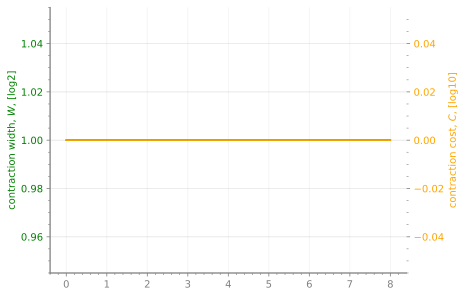

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ax1 = plt.subplots()
    ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green')
    ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange')
    ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

# The whole code (from S's notebook)

In [94]:
#Imports and Installations

!pip install -U git+https://github.com/jcmgray/quimb.git --quiet

%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from math import pi


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [95]:
# def qft_rotations(circuit, qubits):
#     for i in range(len(qubits)):
#         circuit.apply_gate('H', qubits[i], 'contract', False)
#         for j in range(i+1, len(qubits)):
#             lamda = np.pi / 2**(j - i)
#             circuit.apply_gate('CPHASE', lamda, qubits[i], qubits[j])

from quimb.tensor.circuit import Circuit

def circ_qft(num_qubits, random_state, depth,
    **circuit_opts,
):

    circuit_opts.setdefault('gate_opts', {})
    circuit_opts['gate_opts'].setdefault('contract', False)

    n = num_qubits
    gates = []
    qubits=np.arange(n)
    for i in range(num_qubits):
            gates.append(('X', qubits[i]))

    #QFT
    for d in range(depth):
        for i in range(num_qubits):
            gates.append((d, 'h', i)) #H gate
            for j in range(i+1, num_qubits):
                lamda = np.pi / 2**(j - i)
                gates.append((d, 'CPHASE', lamda, qubits[i], qubits[j]))#Cphase

            for i in range(num_qubits//2):
                gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))
                gates.append((d, 'CNOT', qubits[len(qubits)-i-1], qubits[i]))
                gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))





    circ = Circuit(n, **circuit_opts)
    circ.apply_gates(gates)


    return circ

In [96]:
qubits=np.arange(num_qubits)
for i in range(num_qubits//2):
   print(i, len(qubits)-i-1)

0 7
1 6
2 5
3 4


In [97]:
qc= circ_qft(num_qubits, random_state, 1)

EdgeView([(0, 6), (2, 4), (2, 6), (4, 6)])

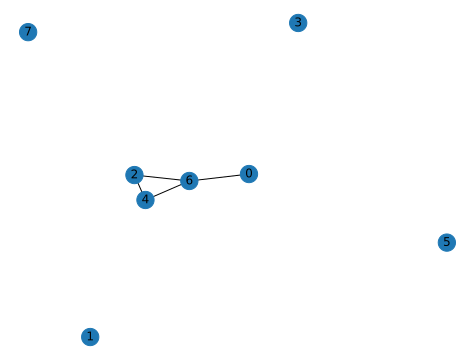

In [98]:
import networkx as nx
import random

# Define the number of nodes
num_nodes = num_qubits

# Calculate the number of edges based on the 2:1 node-to-edge ratio
num_edges = num_nodes // 2

# Create an empty graph
G = nx.Graph(seed = '666')
# nx.draw(G)

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Randomly add edges until the desired number of edges is reached
while G.number_of_edges() < num_edges:
    # Pick two random nodes to connect with an edge
    u, v = random.sample(range(num_nodes), 2)
    # Add the edge if it doesn't already exist
    if not G.has_edge(u, v):
        G.add_edge(u, v)


reg = 3
n = num_qubits
seed = 666
F = nx.random_regular_graph(reg, n, seed=seed)

terms = {(i, j): 1 for i, j in F.edges}
#nx.draw(F, with_labels = True)
# Draw the graph
nx.draw(G, with_labels=True)
# display(nx.edges(G))
G.edges()

In [99]:
import cotengra as ctg
import tqdm

opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={},
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)
# edge=(0,2)

terms = {(i, j): 1 for i, j in G.edges}

ZZ =qu.pauli('Z') & qu.pauli('Z')

local_exp_rehs = [qc.local_expectation_rehearse(ZZ, edge, optimize=opt) for edge, weight in tqdm.tqdm(list(terms.items()))]


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


In [100]:
local_exp_rehs

[{'tn': TensorNetwork(tensors=8, indices=6),
  'tree': <ContractionTree(N=8)>,
  'W': 4.0,
  'C': 2.03342375548695},
 {'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0},
 {'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0},
 {'tn': TensorNetwork(tensors=9, indices=6),
  'tree': <ContractionTree(N=9)>,
  'W': 3.0,
  'C': 1.9242792860618816}]